# Toy example

Original notebook by Alexander Held, edited for the MadMiner repository by Johann Brehmer, Irina Espejo, Felix Kling, and Kyle Cranmer 2018-2019.

In this notebook, we use a simple toy example to demonstrate the machine learning and inference algorithms in MadMiner. This allows us to skip many of the more technical steps, and there's no dependency on MadGraph, Pythia, or Delphes.

What this tutorial does not do, is explaining the inference methods. To understand what's happening, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013), which will explain the basic idea in just a few pages. If you really want to get down to the dirty details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) has you covered.

## Preparations

In [16]:
import os
import logging
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

%matplotlib inline

from madminer.ml import ParameterizedRatioEstimator, ScoreEstimator, BayesianScoreEstimator

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. A toy simulator

Our simulator depends on just one parameter `theta` and produces one-dimensional observables `x`. It is characterized by one latent variable `z`. "Running" the simulator consists of two steps:
- "Hard process": a value of `z` is drawn from a normal distribution, where the mean depends on `theta`. 
- "Detector": a value for `x` is drawn from a normal distribution with mean equal to `z`. There is no explicit dependence on `theta`.

As in the particle physics case, we assume that we can calculate the joint likelihood ratio `r(x, z | theta0, theta1)` as well as the joint score `t(x, z | theta)`, which depend explicitly on `z` (and where the "detector" part cancels).

Here are some general settings (feel free to play with them): 

In [4]:
z_std = 2.0
x_std = 1.0

The following function runs the simulator for a value of `theta` and calculates the joint likelihood ratio between `theta0` and `theta1` as well as the joint score at `theta_score`:

In [5]:
def simulate(theta, theta0=None, theta1=None, theta_score=None, npoints=None):
    # Draw latent variables z
    z = np.random.normal(loc=theta, scale=z_std, size=npoints)

    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    # Calculate joint likelihood ratio and joint score
    if theta0 is not None and theta1 is not None:
        r_xz = norm(loc=theta0, scale=z_std).pdf(z) / norm(loc=theta1, scale=z_std).pdf(z)
    else:
        r_xz = None

    if theta_score is not None:
        t_xz = (x - theta_score) / z_std**2
    else:
        t_xz = None

    return x, r_xz, t_xz

Usually the likelihood function `p(x|theta)` is intractable, but in this toy example it is just given by the convolution of two Gaussians, which is again a Gaussian. We will use this to validate the results later:

In [6]:
def calculate_likelihood_ratio(x, theta0, theta1=0.0):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = norm(loc=theta0, scale=combined_std).pdf(x) / norm(loc=theta1, scale=combined_std).pdf(x)
    return r_x

Let's now visualize that: we run the simulation and plot the probability distributions $p(x | \theta_i)$. Additionally, we also plot the true log-likelihood ratio $\log\,r(x|\theta_0,\theta_1)$. 

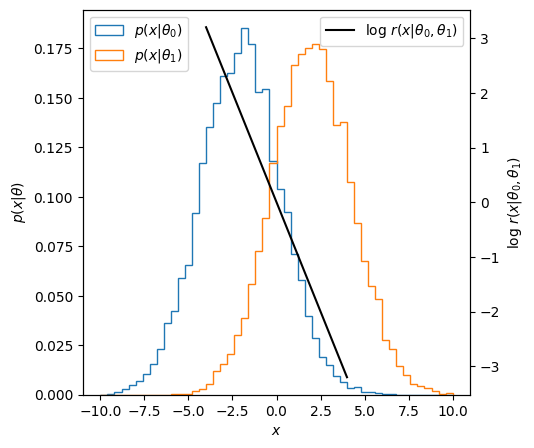

In [7]:
x0, _, _ = simulate(-2, npoints=10000)
x1, _, _ = simulate(2, npoints=10000)

xr = np.linspace(-4.0, 4.0, 100)
rx = np.log(calculate_likelihood_ratio(xr, -2, 2))

fig, ax1 = plt.subplots()
fig.set_size_inches(5, 5)
ax1.set_xlabel("$x$")
ax1.hist(x0, bins=50, range=(-10, 10.0), histtype="step", label=r"$p(x | \theta_0)$", density=True)
ax1.hist(x1, bins=50, range=(-10, 10.0), histtype="step", label=r"$p(x | \theta_1)$", density=True)
ax1.set_ylabel(r"$p(x|\theta)$")
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xr, rx, color="black", label=r"$\log\,r(x|\theta_0,\theta_1)$")
ax2.set_ylabel(r"$\log\,r(x|\theta_0,\theta_1)$")
ax2.legend(loc=1)

plt.show()

## 2. Run the simulation and generate training data

First, we define the parameter points we want to use for training: `theta0` is uniformly distributed while the reference model `theta1` is fixed at zero. 

In [8]:
# number of parameter points to train
n_param_points = 50000

# numerator, uniform prior
theta0 = np.random.uniform(low=-4.0, high=4.0, size=n_param_points)

# denominator: fixed at 0
theta1 = np.zeros(shape=n_param_points)

We then run the simulator (one sample per parameter point). Remember that `simulate(theta, theta0, theta1, theta_score)` generates data `x` following a theory with `theta` and then evaluates the joint likelihood ratio `r(x,z|theta0,theta1)` and the join score `t(x,z|theta_score)` for each data point.

In [9]:
# Sample from theta0
x_from_theta0, r_xz_from_theta0, t_xz_from_theta0 = simulate(theta0, theta0, theta1, theta0)

# Sample from theta1
x_from_theta1, r_xz_from_theta1, t_xz_from_theta1 = simulate(theta1, theta0, theta1, theta1)

Now we combine and reshape the results (nothing interesting happening here) and save everything to files, so that we can load it later.

In [10]:
# Combine results and reshape
x_train = np.hstack((x_from_theta0, x_from_theta1)).reshape(-1, 1)
r_xz_train = np.hstack((r_xz_from_theta0, r_xz_from_theta1)).reshape(-1, 1)
t_xz_train = np.hstack((t_xz_from_theta0, t_xz_from_theta1)).reshape(-1, 1)
y_train = np.hstack((np.zeros_like(x_from_theta0), np.ones_like(np.ones_like(x_from_theta1)))).reshape(-1, 1)
theta0_train = np.hstack((theta0, theta0)).reshape(-1, 1)

# Save to file
np.save("data/theta0_train.npy", theta0_train)
np.save("data/x_train.npy", x_train)
np.save("data/y_train.npy", y_train)
np.save("data/r_xz_train.npy", r_xz_train)
np.save("data/t_xz_train.npy", t_xz_train)

## 3. Model training

Let's train two neural networks to estimate the likelihood ratio. For one we use the CARL method introduced in ["Approximating Likelihood Ratios with Calibrated Discriminative Classifiers"](https://arxiv.org/abs/1506.02169), for the other the new ALICES method introduced in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973).

In [12]:
carl = ParameterizedRatioEstimator(n_hidden=(20, 20))

carl.train(
    method="carl",
    x="data/x_train.npy",
    y="data/y_train.npy",
    theta="data/theta0_train.npy",
    n_epochs=20,
)

carl.save("models/carl")

13:45 madminer.ml.paramete INFO    Starting training
13:45 madminer.ml.paramete INFO      Method:                 carl
13:45 madminer.ml.paramete INFO      Batch size:             128
13:45 madminer.ml.paramete INFO      Optimizer:              amsgrad
13:45 madminer.ml.paramete INFO      Epochs:                 20
13:45 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
13:45 madminer.ml.paramete INFO      Validation split:       0.25
13:45 madminer.ml.paramete INFO      Early stopping:         True
13:45 madminer.ml.paramete INFO      Scale inputs:           True
13:45 madminer.ml.paramete INFO      Scale parameters:       True
13:45 madminer.ml.paramete INFO      Shuffle labels          False
13:45 madminer.ml.paramete INFO      Samples:                all
13:45 madminer.ml.paramete INFO    Loading training data
13:45 madminer.utils.vario INFO      Loading data/theta0_train.npy into RAM
13:45 madminer.utils.vario INFO      Loading data/x_train

13:45 madminer.utils.ml.tr INFO      Epoch   1: train loss  0.62439 (xe:  0.624)
13:45 madminer.utils.ml.tr INFO                 val. loss   0.58971 (xe:  0.590)
13:45 madminer.utils.ml.tr INFO      Epoch   2: train loss  0.59004 (xe:  0.590)
13:45 madminer.utils.ml.tr INFO                 val. loss   0.58658 (xe:  0.587)
13:45 madminer.utils.ml.tr INFO      Epoch   3: train loss  0.58886 (xe:  0.589)
13:45 madminer.utils.ml.tr INFO                 val. loss   0.58590 (xe:  0.586)
13:45 madminer.utils.ml.tr INFO      Epoch   4: train loss  0.58835 (xe:  0.588)
13:45 madminer.utils.ml.tr INFO                 val. loss   0.58666 (xe:  0.587)
13:45 madminer.utils.ml.tr INFO      Epoch   5: train loss  0.58790 (xe:  0.588)
13:45 madminer.utils.ml.tr INFO                 val. loss   0.58513 (xe:  0.585)
13:46 madminer.utils.ml.tr INFO      Epoch   6: train loss  0.58745 (xe:  0.587)
13:46 madminer.utils.ml.tr INFO                 val. loss   0.58429 (xe:  0.584)
13:46 madminer.utils.ml.tr I

In [13]:
alices = ParameterizedRatioEstimator(n_hidden=(20, 20))

alices.train(
    method="alices",
    x="data/x_train.npy",
    y="data/y_train.npy",
    theta="data/theta0_train.npy",
    r_xz="data/r_xz_train.npy",
    t_xz="data/t_xz_train.npy",
    alpha=0.1,
    n_epochs=20,
)

alices.save("models/alices")

13:48 madminer.ml.paramete INFO    Starting training
13:48 madminer.ml.paramete INFO      Method:                 alices
13:48 madminer.ml.paramete INFO      alpha:                  0.1
13:48 madminer.ml.paramete INFO      Batch size:             128
13:48 madminer.ml.paramete INFO      Optimizer:              amsgrad
13:48 madminer.ml.paramete INFO      Epochs:                 20
13:48 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
13:48 madminer.ml.paramete INFO      Validation split:       0.25
13:48 madminer.ml.paramete INFO      Early stopping:         True
13:48 madminer.ml.paramete INFO      Scale inputs:           True
13:48 madminer.ml.paramete INFO      Scale parameters:       True
13:48 madminer.ml.paramete INFO      Shuffle labels          False
13:48 madminer.ml.paramete INFO      Samples:                all
13:48 madminer.ml.paramete INFO    Loading training data
13:48 madminer.utils.vario INFO      Loading data/theta0_train.npy

13:48 madminer.utils.ml.tr INFO      Epoch   1: train loss  0.63899 (improved_xe:  0.610, mse_score:  0.293)
13:48 madminer.utils.ml.tr INFO                 val. loss   0.59186 (improved_xe:  0.586, mse_score:  0.058)
13:48 madminer.utils.ml.tr INFO      Epoch   2: train loss  0.59017 (improved_xe:  0.587, mse_score:  0.033)
13:48 madminer.utils.ml.tr INFO                 val. loss   0.58729 (improved_xe:  0.585, mse_score:  0.024)
13:48 madminer.utils.ml.tr INFO      Epoch   3: train loss  0.58782 (improved_xe:  0.586, mse_score:  0.017)
13:48 madminer.utils.ml.tr INFO                 val. loss   0.58595 (improved_xe:  0.584, mse_score:  0.016)
13:48 madminer.utils.ml.tr INFO      Epoch   4: train loss  0.58720 (improved_xe:  0.586, mse_score:  0.013)
13:48 madminer.utils.ml.tr INFO                 val. loss   0.58566 (improved_xe:  0.584, mse_score:  0.014)
13:49 madminer.utils.ml.tr INFO      Epoch   5: train loss  0.58693 (improved_xe:  0.586, mse_score:  0.011)
13:49 madminer.util

In [11]:
sally = ScoreEstimator(n_hidden=(20, 20))

sally.train(
    method="sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=5,
)

sally.save("models/sally")

10:31 madminer.ml.score    INFO    Starting training
10:31 madminer.ml.score    INFO      Batch size:             128
10:31 madminer.ml.score    INFO      Optimizer:              amsgrad
10:31 madminer.ml.score    INFO      Epochs:                 5
10:31 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
10:31 madminer.ml.score    INFO      Validation split:       0.25
10:31 madminer.ml.score    INFO      Early stopping:         True
10:31 madminer.ml.score    INFO      Scale inputs:           True
10:31 madminer.ml.score    INFO      Shuffle labels          False
10:31 madminer.ml.score    INFO      Samples:                all
10:31 madminer.ml.score    INFO    Loading training data
10:31 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
10:31 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
10:31 madminer.ml.score    INFO    Found 100000 samples with 1 parameters and 1 observables
10:31 madminer.ml.base     IN

10:32 madminer.utils.ml.tr INFO      Epoch   1: train loss  0.11735 (mse_score:  0.117)
10:32 madminer.utils.ml.tr INFO                 val. loss   0.10871 (mse_score:  0.109)
10:32 madminer.utils.ml.tr INFO      Epoch   2: train loss  0.10909 (mse_score:  0.109)
10:32 madminer.utils.ml.tr INFO                 val. loss   0.10783 (mse_score:  0.108)
10:32 madminer.utils.ml.tr INFO      Epoch   3: train loss  0.10870 (mse_score:  0.109)
10:32 madminer.utils.ml.tr INFO                 val. loss   0.10788 (mse_score:  0.108)
10:32 madminer.utils.ml.tr INFO      Epoch   4: train loss  0.10857 (mse_score:  0.109)
10:32 madminer.utils.ml.tr INFO                 val. loss   0.10757 (mse_score:  0.108)
10:32 madminer.utils.ml.tr INFO      Epoch   5: train loss  0.10850 (mse_score:  0.109)
10:32 madminer.utils.ml.tr INFO                 val. loss   0.10771 (mse_score:  0.108)
10:32 madminer.utils.ml.tr INFO    Early stopping after epoch 4, with loss  0.10757 compared to final loss  0.10771
10:3

We can also try a little bit of mixing and matching -- let's train a model with CARL first and then with ALICES:

In [35]:
from madminer.ml import ParameterizedRatioEstimator, ScoreEstimator, BayesianScoreEstimator

In [47]:
bayes_sally = BayesianScoreEstimator(n_hidden=(20, 20))

bayes_sally.train(
    method="bayesian_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=20,
)

bayes_sally.save("models/bayes_sally")

11:17 madminer.ml.score    INFO    Starting training
11:17 madminer.ml.score    INFO      Batch size:             128
11:17 madminer.ml.score    INFO      Optimizer:              amsgrad
11:17 madminer.ml.score    INFO      Epochs:                 20
11:17 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:17 madminer.ml.score    INFO      Validation split:       0.25
11:17 madminer.ml.score    INFO      Early stopping:         True
11:17 madminer.ml.score    INFO      Scale inputs:           True


11:17 madminer.ml.score    INFO      Shuffle labels          False
11:17 madminer.ml.score    INFO      Samples:                all
11:17 madminer.ml.score    INFO    Loading training data
11:17 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
11:17 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
11:17 madminer.ml.score    INFO    Found 100000 samples with 1 parameters and 1 observables
11:17 madminer.ml.base     INFO    Setting up input rescaling
11:17 madminer.ml.score    INFO    Creating model
11:17 madminer.ml.score    INFO    Training model
11:17 madminer.utils.ml.tr INFO    Training on CPU with single precision
11:17 madminer.utils.ml.tr INFO      Epoch   1: train loss 13.47844 (bayesian_loss: 13.478)
11:17 madminer.utils.ml.tr INFO                 val. loss  12.95272 (bayesian_loss: 12.953)
11:17 madminer.utils.ml.tr INFO      Epoch   2: train loss 12.31599 (bayesian_loss: 12.316)
11:17 madminer.utils.ml.tr INFO                 val. loss  11.9

## 4. Generate evaluation data

Let us now generate some test data, which is sampled corresponding to `theta=1`

In [15]:
n_param_points_test = 1000  # number of parameter points to test
theta_test = 1.0 * np.ones(shape=n_param_points_test).reshape(-1, 1)

Run the simulator to get observations:

In [16]:
x_test, _, _ = simulate(theta_test)
np.save("data/x_test.npy", x_test)

We want to evaluate the expected likelihood ratio on a range of parameter points:

In [17]:
theta_grid = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)
np.save("data/theta_grid.npy", theta_grid)

In this toy example, we can calculate the true likelihood ratio. We will save the expected log likelihood ratio (multiplied with a conventional factor of -2):

In [18]:
all_log_r_test_true = []
nllr_test_true = []

for theta in theta_grid:
    log_r = np.log(calculate_likelihood_ratio(x_test, theta))
    nllr_test_true.append(-2.0 * np.mean(log_r))
    all_log_r_test_true.append(log_r)

all_log_r_test_true = np.asarray(all_log_r_test_true).reshape((100, n_param_points_test))
nllr_test_true = np.asarray(nllr_test_true)

## 5. Evaluation

It's time to evaluate our likelihood ratio estimators!

In [19]:
carl = ParameterizedRatioEstimator()
carl.load("models/carl")

log_r, _ = carl.evaluate(
    theta="data/theta_grid.npy",
    x="data/x_test.npy",
    evaluate_score=False,
)

nllr_test_carl = -2.0 * np.mean(log_r, axis=1)
mse_carl = np.mean((all_log_r_test_true - log_r) ** 2)
print("MSE:", mse_carl)

13:55 madminer.ml.base     INFO    Loading model from models/carl
13:55 madminer.utils.vario INFO      Loading data/x_test.npy into RAM
13:55 madminer.utils.vario INFO      Loading data/theta_grid.npy into RAM


MSE: 0.31784697750630525


In [20]:
alices = ParameterizedRatioEstimator()
alices.load("models/alices")

log_r, _ = alices.evaluate(
    theta="data/theta_grid.npy",
    x="data/x_test.npy",
    evaluate_score=False,
)

nllr_test_alices = -2.0 * np.mean(log_r, axis=1)
mse_alices = np.mean((all_log_r_test_true - log_r) ** 2)
print("MSE:", mse_alices)

13:55 madminer.ml.base     INFO    Loading model from models/alices
13:55 madminer.utils.vario INFO      Loading data/x_test.npy into RAM
13:55 madminer.utils.vario INFO      Loading data/theta_grid.npy into RAM


MSE: 0.04659125712892735


This is the expected log likelihood ratio over parameter space:

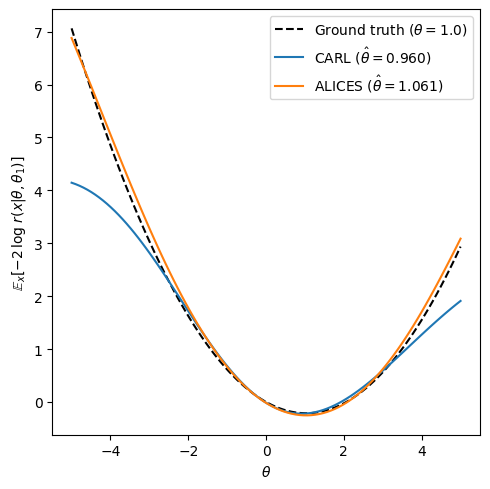

In [21]:
best_fit_alices = float(theta_grid[np.argmin(nllr_test_alices)])
best_fit_carl = float(theta_grid[np.argmin(nllr_test_carl)])

fig = plt.figure(figsize=(5, 5))

plt.plot(
    theta_grid,
    nllr_test_true,
    ls="--",
    c="black",
    label=r"Ground truth ($\theta = 1.0$)",
)
plt.plot(
    theta_grid,
    nllr_test_carl,
    label=r"CARL ($\hat{\theta} = " + "{:.3f}$)".format(best_fit_carl),
)
plt.plot(
    theta_grid,
    nllr_test_alices,
    label=r"ALICES ($\hat{\theta} = " + "{:.3f}$)".format(best_fit_alices),
)

plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_x [ -2\, \log \,r(x | \theta, \theta_{1}) ]$")

plt.legend()
plt.tight_layout()
plt.show()

## Score evaluation

In [24]:
n_param_points_test = 1000  # number of parameter points to test
theta_test = 1.0 * np.zeros(shape=n_param_points_test).reshape(-1, 1)

In [25]:
x_test, _, _ = simulate(theta_test)
np.save("data/x_test.npy", x_test)

In [26]:
alices = ParameterizedRatioEstimator()
alices.load("models/alices")

log_r, t_hat = alices.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
    evaluate_score=True,
)

11:02 madminer.ml.base     INFO    Loading model from models/alices
11:02 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [27]:
sally = ScoreEstimator()
sally.load("models/sally")

t_hat_sally = sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)

11:02 madminer.ml.base     INFO    Loading model from models/sally
11:02 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [48]:
bayes_sally = BayesianScoreEstimator()
bayes_sally.load("models/bayes_sally")

t_hat_bayes_sally, t_hat_sig_bayes_sally = bayes_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)

13:06 madminer.ml.base     INFO    Loading model from models/bayes_sally
13:06 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [49]:
def calculate_true_score(x, theta0, theta1=0):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = (x - theta1)/combined_std**2
    return r_x

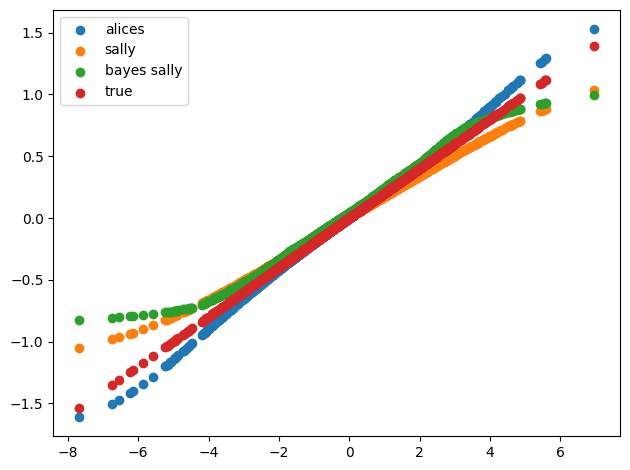

In [50]:
x = np.load("data/x_test.npy")
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

plt.scatter(x, t_hat.flatten(), label='alices')
plt.scatter(x, t_hat_sally.flatten(), label='sally')
plt.scatter(x, t_hat_bayes_sally.flatten(), label='bayes sally')
plt.scatter(x, t_hat_true, label='true')

plt.legend()

plt.tight_layout()
plt.show()

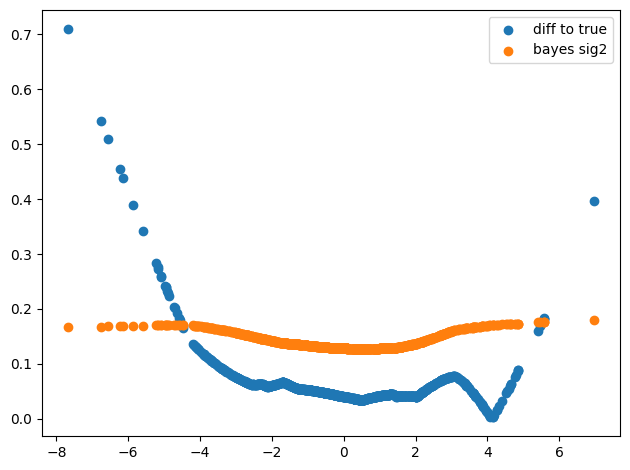

In [51]:
fig = plt.figure()

plt.scatter(x, np.abs(t_hat_bayes_sally.flatten() - t_hat_true.flatten()), label='diff to true')
plt.scatter(x, t_hat_sig_bayes_sally.flatten(), label='bayes sig2')

plt.legend()

plt.tight_layout()
plt.show()